# [STARTER] Udaplay Project

## Part 01 - Offline RAG

In this part of the project, you'll build your VectorDB using Chroma.

The data is inside folder `project/starter/games`. Each file will become a document in the collection you'll create.
Example.:
```json
{
  "Name": "Gran Turismo",
  "Platform": "PlayStation 1",
  "Genre": "Racing",
  "Publisher": "Sony Computer Entertainment",
  "Description": "A realistic racing simulator featuring a wide array of cars and tracks, setting a new standard for the genre.",
  "YearOfRelease": 1997
}
```


### Setup

In [1]:
# Only needed for Udacity workspace

import importlib.util
import sys

# Check if 'pysqlite3' is available before importing
if importlib.util.find_spec("pysqlite3") is not None:
    import pysqlite3
    sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [2]:
import os
import json
import pathlib
import chromadb
from openai import OpenAI
from chromadb.utils import embedding_functions
from dotenv import load_dotenv

In [3]:
# Load environment variables from config.env
load_dotenv('config.env')

assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('TAVILY_API_KEY') is not None
assert os.getenv('CHROMA_OPENAI_API_KEY') is not None

In [4]:
# Verify that the API keys are set correctly
client = OpenAI(
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv('OPENAI_API_KEY'),  
)
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hi!"}
]

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=messages,
    temperature=0.7
)

print(response.choices[0].message.content)


Hello! How can I help you today?


### VectorDB Instance

In [5]:
# Instantiate a ChromaDB persistent client
CHROMA_DB_PATH = "chromadb"
db_path = pathlib.Path(CHROMA_DB_PATH)
if not db_path.exists():
    db_path.mkdir(parents=True, exist_ok=True)

chroma_client = chromadb.Client(
    settings=chromadb.config.Settings(
        persist_directory=CHROMA_DB_PATH,
        is_persistent=True
    )
)

print(f"ChromaDB persistent client ready...")

ChromaDB persistent client ready...


### Collection

In [6]:
# Creating an embedding function using OpenAI's API
embedding_model = "text-embedding-3-small"

embedding_fn = embedding_functions.OpenAIEmbeddingFunction(
    api_key=os.getenv('OPENAI_API_KEY'),
    api_base="https://openai.vocareum.com/v1",
    model_name=embedding_model
)

In [7]:
# Create a ChromaDB collection with the embedding function
collection = chroma_client.get_or_create_collection(
    name="udaplay",
    embedding_function=embedding_fn,
    metadata={"hnsw:space": "cosine"}
)

print(f"Collection {collection.name} ready — {collection.count()} docs ({embedding_model} embeddings).")

Collection udaplay ready — 15 docs (text-embedding-3-small embeddings).


### Add documents

In [8]:
# Add documents to the collection from the games dataset
data_dir = "games"
games_loaded = []

for file_name in sorted(os.listdir(data_dir)):
    if not file_name.endswith(".json"):
        continue
    with open(os.path.join(data_dir, file_name), "r", encoding="utf-8") as f:
        game = json.load(f)

    # Rich text representation for embedding
    content = (
        f"[{game['Platform']}] {game['Name']} ({game['YearOfRelease']}) "
        f"— Genre: {game['Genre']}. Publisher: {game['Publisher']}. "
        f"{game['Description']}"
    )
    doc_id = os.path.splitext(file_name)[0]

    collection.add(
        ids=[doc_id],
        documents=[content],
        metadatas=[game],
    )
    games_loaded.append(game)
    print(f"  [{doc_id}] {game['Name']} — {game['Platform']} ({game['YearOfRelease']})")

print(f"\n{len(games_loaded)} games loaded — collection now has {collection.count()} documents")

  [001] Gran Turismo — PlayStation 1 (1997)
  [002] Grand Theft Auto: San Andreas — PlayStation 2 (2004)
  [003] Gran Turismo 5 — PlayStation 3 (2010)
  [004] Marvel's Spider-Man — PlayStation 4 (2018)
  [005] Marvel's Spider-Man 2 — PlayStation 5 (2023)
  [006] Pokémon Gold and Silver — Game Boy Color (1999)
  [007] Pokémon Ruby and Sapphire — Game Boy Advance (2002)
  [008] Super Mario World — Super Nintendo Entertainment System (SNES) (1990)
  [009] Super Mario 64 — Nintendo 64 (1996)
  [010] Super Smash Bros. Melee — GameCube (2001)
  [011] Wii Sports — Wii (2006)
  [012] Mario Kart 8 Deluxe — Nintendo Switch (2017)
  [013] Kinect Adventures! — Xbox 360 (2010)
  [014] Minecraft — Xbox One (2014)
  [015] Halo Infinite — Xbox Series X|S (2021)
  [016] The Legend of Zelda: Breath of the Wild — Nintendo Switch (2017)
  [017] Elden Ring — PlayStation 5 (2022)
  [018] The Witcher 3: Wild Hunt — PlayStation 4 (2015)
  [019] Red Dead Redemption 2 — PlayStation 4 (2018)
  [020] God of War R

### Semantic search

In [14]:
def semantic_search(query: str, n_results: int = 3):
    """Pretty-print semantic search results from the collection."""
    results = collection.query(
        query_texts=[query],
        n_results=n_results,
        include=["documents", "distances", "metadatas"],
    )
    print(f"\nQuery: '{query}'")
    print("─" * 60)
    for i, (doc, dist, meta) in enumerate(
        zip(results["documents"][0], results["distances"][0], results["metadatas"][0])
    ):
        print(f"#{i+1}  distance={dist:.4f}")
        print(f"{meta['Name']} | {meta['Platform']} | {meta['YearOfRelease']}")
        print(f"Genre: {meta['Genre']}  •  Publisher: {meta['Publisher']}")
        print()
    return results

In [15]:
_=semantic_search("open-world RPG with deep story")


Query: 'open-world RPG with deep story'
────────────────────────────────────────────────────────────
#1  distance=0.5645
The Witcher 3: Wild Hunt | PlayStation 4 | 2015
Genre: Action RPG  •  Publisher: CD Projekt

#2  distance=0.5844
Elden Ring | PlayStation 5 | 2022
Genre: Action RPG  •  Publisher: Bandai Namco Entertainment

#3  distance=0.6285
Red Dead Redemption 2 | PlayStation 4 | 2018
Genre: Action-Adventure  •  Publisher: Rockstar Games



### Knowledge Base Visualization

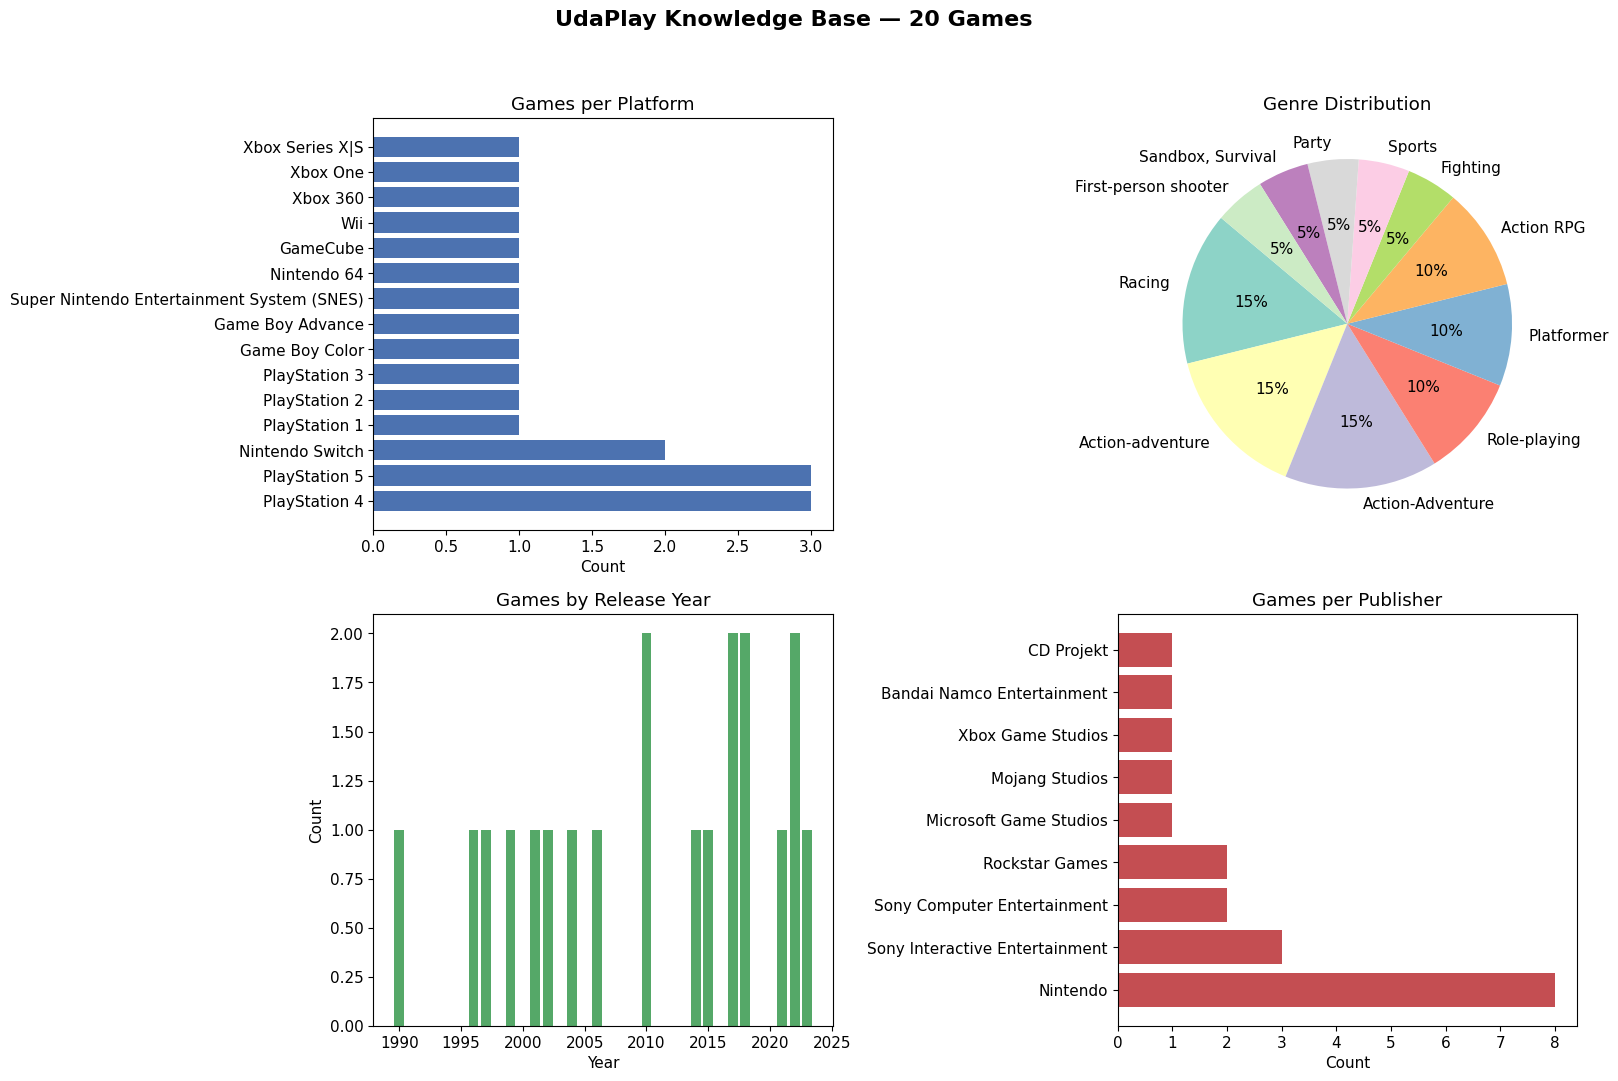


Dashboard saved to knowledge_base_dashboard.png


In [11]:
import matplotlib
from collections import Counter
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.size": 11})

# Data prep for visualizations
platforms  = [g["Platform"] for g in games_loaded]
genres     = [g["Genre"]    for g in games_loaded]
publishers = [g["Publisher"] for g in games_loaded]
years      = sorted([g["YearOfRelease"] for g in games_loaded])

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle("UdaPlay Knowledge Base — 20 Games", fontsize=16, fontweight="bold")

# Games per platform
plat_counts = Counter(platforms)
plat_sorted = plat_counts.most_common()
axes[0, 0].barh([p for p, _ in plat_sorted], [c for _, c in plat_sorted], color="#4C72B0")
axes[0, 0].set_title("Games per Platform")
axes[0, 0].set_xlabel("Count")

# Genre distribution
genre_counts = Counter(genres)
labels, sizes = zip(*genre_counts.most_common())
colors = plt.cm.Set3.colors[:len(labels)]
axes[0, 1].pie(sizes, labels=labels, autopct="%1.0f%%", colors=colors, startangle=140)
axes[0, 1].set_title("Genre Distribution")

# Release year timeline
year_counts = Counter(years)
all_years = list(range(min(years), max(years) + 1))
counts = [year_counts.get(y, 0) for y in all_years]
axes[1, 0].bar(all_years, counts, color="#55A868", width=0.8)
axes[1, 0].set_title("Games by Release Year")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Count")

# Publisher breakdown
pub_counts = Counter(publishers)
pub_sorted = pub_counts.most_common()
axes[1, 1].barh([p for p, _ in pub_sorted], [c for _, c in pub_sorted], color="#C44E52")
axes[1, 1].set_title("Games per Publisher")
axes[1, 1].set_xlabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("knowledge_base_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()
print("\nDashboard saved to knowledge_base_dashboard.png")

### Reusable VectorStoreManager

In [12]:
# Reload the modified lib modules
import importlib, lib.vector_db, lib.llm
importlib.reload(lib.vector_db)
importlib.reload(lib.llm)
from lib.documents import Document, Corpus
from lib.vector_db import VectorStoreManager, VectorStore

manager = VectorStoreManager(
    openai_api_key=os.getenv('OPENAI_API_KEY'),
    api_base="https://openai.vocareum.com/v1"
)

manager.chroma_client = chroma_client
manager.embedding_function = embedding_fn

store = manager.get_or_create_store("udaplay")

corpus = Corpus()
for file_name in sorted(os.listdir(data_dir)):
    if not file_name.endswith(".json"):
        continue
    with open(os.path.join(data_dir, file_name), "r", encoding="utf-8") as f:
        game = json.load(f)
    content = (
        f"[{game['Platform']}] {game['Name']} ({game['YearOfRelease']}) "
        f"— Genre: {game['Genre']}. Publisher: {game['Publisher']}. "
        f"{game['Description']}"
    )
    corpus.append(Document(id=os.path.splitext(file_name)[0], content=content, metadata=game))

store.add(corpus)
print(f"VectorStoreManager — {len(corpus)} documents added")

VectorStoreManager — 20 documents added


In [13]:
results = store.query(query_texts=["open-world RPG with deep story"], n_results=3)
for doc, meta in zip(results["documents"][0], results["metadatas"][0]):
    print(f"• {meta['Name']} ({meta['Platform']}, {meta['YearOfRelease']})")

• The Witcher 3: Wild Hunt (PlayStation 4, 2015)
• Elden Ring (PlayStation 5, 2022)
• Red Dead Redemption 2 (PlayStation 4, 2018)
